In [1]:
include("notebook_preamble.jl");

# Interpolating Hamiltonians

In [2]:
function Œ∑energyvariance(H, Œ∑)
    Es = eigvals(H)
    Es .-= minimum(Es) # Shift energies for numerics
    Z = sum(exp(-Œ∑*E) for E in Es)
    Ps = [exp(-Œ∑*E) / Z for E in Es]
    H1 = sum(E * P for (E, P) in zip(Es, Ps))
    H2 = sum(E^2 * P for (E, P) in zip(Es, Ps))
    H2 - H1^2
end;

We map $E \mapsto E / \eta$ so that $\eta$ is a dimensionless inverse temperature $\beta$.

In [3]:
trnorm(A) = ‚àö(tr(A'*A))
trnormalize(A) = A / trnorm(A)
‚à†(A, B) = acos(trnorm(trnormalize(A)' * trnormalize(B)))
function slerp(A, B, g)
    Œ∏ = ‚à†(A, B)
    (sin((1-g)*Œ∏)*A + sin(g*Œ∏)*B) / sin(Œ∏)
end

# Requirement: `normslerp` must not change the reference Hamiltonian.
function normslerp(A, B, g)
    C = slerp(A, B, g)
    C /= trnorm(C)
end

Ainvar(g, H0, Œ∑) = find_zero(A -> Œ∑energyvariance(H0(0.5), Œ∑) - Œ∑energyvariance(A*H0(g), Œ∑), 1.0)
function Hinterp(H1, H2, Œ∑=1.0)
    H0(g) = normslerp(trnormalize(H1), trnormalize(H2), g)
#     g -> Ainvar(g, H0, Œ∑) * H0(g)
    H0
end;

The Ising interaction and transverse-field Hamiltonians are

In [4]:
Hx(n) = -sum(siteop(œÉx, i, n) * siteop(œÉx, i+1, n) for i in 1:n)
Hz(n) = -sum(siteop(œÉz, i, n) for i in 1:n);

In [5]:
Hp = Hinterp(Hx(4), Hz(4));

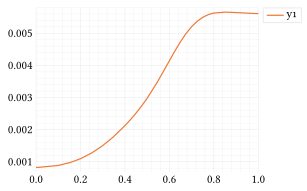

In [6]:
Œ∑0 = 1.5e1
H0(g) = normslerp(trnormalize(Hx(4)), trnormalize(Hz(4)), g)
Hinvar = Hinterp(Hx(4), Hz(4), Œ∑0)
plot(g -> Œ∑energyvariance(H0(g), Œ∑0), xlim=(0.0, 1.0))

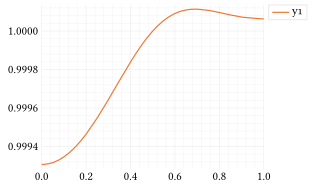

In [7]:
plot(g -> Ainvar(g, H0, 1.8e-1), xlim=(0.0, 1.0))

In [8]:
lgs = range(1e-3, 1-1e-3, length=64)
energies = [eigvals(Hp(g)) for g in lgs]
Hnorms = [trnorm(Hp(g))^2 for g in lgs]
energydifferences = [[x - y for (x, y) in Iterators.product(Es, Es)] for Es in energies];

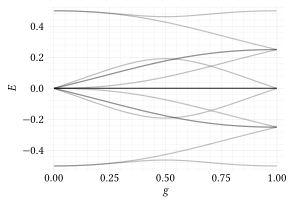

In [9]:
plot(lgs, hcat(energies...)', color=:black, alpha=0.25, key=false, xlabel=L"g", ylabel=L"E")

# Computation of jump operators

In [10]:
function addentry!(dict, key, value; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            push!(dict[k], value)
            return dict
        end
    end
    dict[key] = [value]
    dict
end;

function incentry!(dict, key; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            dict[k] += 1
            return dict
        end
    end
    dict[key] = 1
    dict
end;

firstvalue(i, (x, y)) = x
lastvalue(i, (x, y)) = y
dictmap(f, dict) = Dict(key => f(value) for (key, value) in dict)
function dictby(A; isequal=isequal, keyof=firstvalue, valof=lastvalue)
    i0, x0 = 1, first(A)
    k0, v0 = keyof(i0, x0), valof(i0, x0)
    dict = Dict(k0 => typeof(v0)[])
    dict = Dict()
    for (i, x) in enumerate(A)
        k, v = keyof(i, x), valof(i, x)
        addentry!(dict, k, v, isequal=isequal)
    end
    dict
end;

sumprojector(A) = sum(a * a' for a in A)
projectors(eigdict) = dictmap(sumprojector, eigdict);

function combinejumps(Js)
    d = Dict()
    for J in Js
        incentry!(d, J)
    end
    [‚àö(one(eltype(J)) * N)*J for (J, N) in d]
end;

isequalto(atol=1e-9) = (x, y) -> isapprox(x, y, atol=atol)
function jumps(vals, vecs, As; combine=true, isequal=isequalto())
    eigendict = dictby(zip(vals, vecs))
    œâs = dictby(((E2 - E1, (E1, E2)) for E1 in keys(eigendict), E2 in keys(eigendict)),
        isequal=isequal)
    Œ†s = projectors(eigendict)
    Jœâs = dictmap(œâs) do ŒîEs
        filter(x -> !isequal(x, zero(x)),
            [sum(Œ†s[E1]*A*Œ†s[E2] for (E1, E2) in ŒîEs) for A in As])
    end
    combine ? dictmap(combinejumps, Jœâs) : Jœâs
end

op_to_spindim(H) = Int(log2(size(H)[1]))
dipole_interactions(n) = vcat(map(A -> [siteop(A, i, n) for i in 1:n], [œÉx, œÉy, œÉz])...)
function dipolejumps(H; kwargs...)
    vals, vecs = eigen(H)
    jumps(vals, eachcol(vecs), dipole_interactions(op_to_spindim(H)); kwargs...)
end;

# Numerical solution of the Lindblad equation

In [11]:
g = 0.5
n = 5
b = SpinBasis(1//2)
sys = ‚äó(repeat([b], n)...)
Hint = Hinterp(Hx(n), Hz(n))
Hsys = Hint(g)
Jœâs = dipolejumps(Hsys)
Œ∑ = 1e1
Œ± = 1e0 # Large Œ± means that Lamb shift dominates. For relaxation illustration only.
Œ© = 1e1
up = spinup(b)
œà0 = ‚äó(repeat([up], n)...)
œÅ0 = projector(œà0)
op = dense(embed(sys, 1, sigmaz(b)));

In [12]:
jumpops, rates = [], Float64[]
Œ≥(œâ, Œ∑) = (1e-1 < Œ∑*œâ ? œâ^3 * (1 + 1 / (exp(Œ∑*œâ) - 1)) : œâ^2 / Œ∑)
for (œâ, Js) in Jœâs
    for J in Js
        push!(rates, Œ± * Œ≥(œâ, Œ∑))
        push!(jumpops, DenseOperator(sys, J))
    end
end
lambham = -Œ± * (Œ© / œÄ) * sum(œâ * J' * J for (œâ, Js) in Jœâs for J in Js);

In [13]:
function fout(t, œÅ)
    œÅ = normalize(œÅ)
    real(expect(op, œÅ))
end
Hspin = DenseOperator(sys, Hsys)
Hopen = DenseOperator(sys, Hsys + lambham)
opth = fout(0.0, thermalstate(Hspin, 1e0))
tf = 2*n^2 / (Œ± * Œ≥(1.0, Œ∑))
ts = range(0.0, tf, length=501);

In [14]:
# _, fouts0 = timeevolution.schroedinger(ts, œà0, Hspin; fout=fout)
# _, fouts1 = timeevolution.schroedinger(ts, œà0, Hopen; fout=fout)
_, fouts = timeevolution.master(ts, œÅ0, Hopen, jumpops; rates=rates, fout=fout)
_, foutsd = timeevolution.master(ts, œÅ0, 0*Hspin, jumpops; rates=rates, fout=fout);

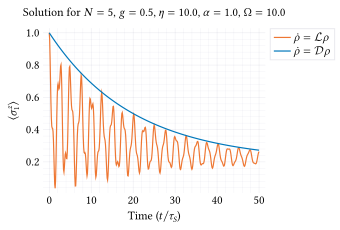

In [15]:
plot(
    title=L"Solution for $N = %$n$, $g = %$g$, $\eta = %$Œ∑$, $\alpha = %$Œ±$, $\Omega = %$Œ©$",
    xlabel=L"Time ($t / \tau_S$)",
    ylabel=L"\ev{\pauli_1^z}",
)
# plot!(ts, [fouts0 fouts1 fouts foutsd], label=["Closed" L"Closed (with $\ham_{LS}$)" "Open" "Dissipator"])
plot!(ts, [fouts foutsd], label=[L"\dot{\dop} = \sopr{L}\dop" L"\dot{\dop} = \sopr{D}\dop"])

In [16]:
savefig("time-evolution-$(n).pdf")

In [17]:
@. decay_exponential(x, p) = foutsd[end] + p[1]*exp(x*p[2])
p0 = [1.0, Œ± * Œ≥(1, Œ∑)]
fit = curve_fit(decay_exponential, ts, foutsd, p0)
coef(fit)

2-element Vector{Float64}:
  0.7561465114487986
 -0.06263476313864966

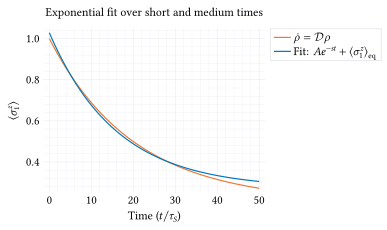

In [18]:
plot(ts, foutsd, label=L"\dot{\dop} = \sopr{D}\dop",
    title="Exponential fit over short and medium times",
    xlabel=L"Time ($t / \tau_S$)",
    ylabel=L"\ev{\pauli_1^z}")
plot!(ts, decay_exponential(ts, coef(fit)), label=L"Fit: $Ae^{-s t} + \ev{\pauli_1^z}_\text{eq}$")

In [19]:
savefig("exponential-fit-$(n).pdf")

# Obtaining relaxation from spaghetti (diagrams)

\begin{equation}
    \dop_S(t)
    = \sum_i c_i(0) e^{-s_i t} \opr{V}_i
    \label{eq:liou-decomposition}
\end{equation}

In [22]:
@. decay_exponential(x, p) = p[1]*exp(x*p[2])
function effective_rate(‚Ñírates, ‚Ñíops, œÅ0, op, Œ∑)
    cs = hcat([vec(V.data) for V in ‚Ñíops]...) \ vec(œÅ0.data)
    V0s = [tr(op * V) for V in ‚Ñíops]
    tf = 2 * op_to_spindim(œÅ0)^2 / Œ≥(1.0, Œ∑)
    ts = range(0, tf, length=501)
    ys = real(sum(@. c * V0 * exp(real(s)*ts) for (s, c, V0) in zip(‚Ñírates, cs, V0s)))
    p0 = [1.0, -1.0 / Œ∑]
    yf = real(cs[1] * V0s[1])
    fit = curve_fit(decay_exponential, ts, ys .- yf, p0)
    fit.converged || error("Could not fit an effective exponential.")
    coef(fit)[2], stderror(fit)[2]
end

Œ≥(œâ, Œ∑) = (1e-1 < Œ∑*œâ ? œâ^3 * (1 + 1 / (exp(Œ∑*œâ) - 1)) : œâ^2 / Œ∑)
function ùíü_rates(H, n = op_to_spindim(H); Œ∑=1.0, œÅ0, op)
    Jœâs = dipolejumps(H)
    sys = œÅ0.basis_r
    jumpops, rates = [], Float64[]
    for (œâ, Js) in Jœâs
        for J in Js
            push!(rates, Œ≥(œâ, Œ∑))
            push!(jumpops, DenseOperator(sys, J))
        end
    end
    # Just the dissipator suffices.
    ‚Ñí = steadystate.liouvillian(DenseOperator(sys), jumpops; rates=rates)
    ‚Ñírates, ‚Ñíops = steadystate.liouvillianspectrum(‚Ñí; nev=4^n)
    effrate = effective_rate(‚Ñírates, ‚Ñíops, œÅ0, op, Œ∑)
    sort(real(‚Ñírates)), effrate...
end;

In [23]:
function plot_ùíü_rates(Hint;
        points=16, Œ∑=1.0, œÅ0, op, onplot=false,
        spectrum=true, extremes=true, effective=true,
        kwargs...)
    g0s = range(1e-3, 1-1e-3, length=points)
    outs = map(g -> ùíü_rates(Hint(g); Œ∑, œÅ0, op), g0s)
    rates = [o[1] for o in outs]
    r0 = [o[2] for o in outs]
    œÉr0 = [o[3] for o in outs]
    
    p = onplot
    if onplot == false
        p = plot(
            xlabel=L"Hamiltonian parameter $g$",
            ylabel=L"Dissipaton rates ($\tilde{\gamma} / \tilde{\gamma}_0$)",
            legendtitle=L"\log\eta",
            legend=:topright;
            kwargs...)
    end
    if spectrum
        plot!(p, g0s, -hcat(rates...)', color=:black, alpha=0.25, label=false)
        
        if extremes
            rates0 = ùíü_rates(Hint(0); Œ∑, œÅ0, op)[1]
            rates1 = ùíü_rates(Hint(1); Œ∑, œÅ0, op)[1]
            scatter!(p, repeat([g0s[1] - 2e-2], length(rates0)), -rates0,
                marker=(:rtriangle, 2, rubric), markerstrokecolor=rubric, label=false)
            scatter!(p, repeat([g0s[end] + 2e-2], length(rates1)), -rates1,
                marker=(:ltriangle, 2, rubric), markerstrokecolor=rubric, label=false)
        end
    end
    if effective
        plot!(p, g0s, -r0, ribbon=œÉr0, label=L"%$(round(log10(Œ∑), digits=1))",
            color = (onplot == false) ? rubric : :auto)
    end
    p
end;

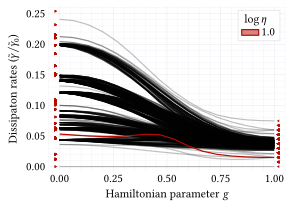

In [24]:
plot_ùíü_rates(Hint; Œ∑, œÅ0, op)

In [25]:
savefig("spin-spectrum-$(n).pdf")

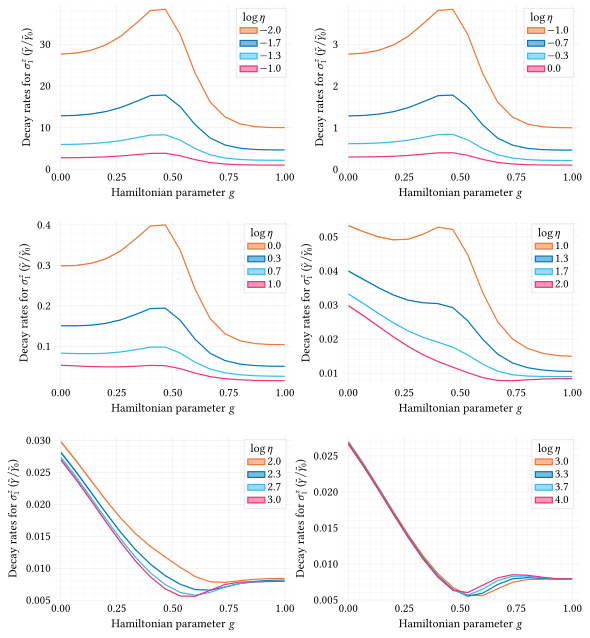

In [26]:
plot([reduce((p, Œ∑) ->
            plot_ùíü_rates(Hint; Œ∑, œÅ0, op, spectrum=false, onplot=p),
            10 .^ range(lŒ∑, lŒ∑ + 1, length=4);
            init = plot(size=2 .* (400, 300 * 3//2),
                xlabel=L"Hamiltonian parameter $g$",
                ylabel=L"Decay rates for $\pauli_1^z$ ($\tilde{\gamma} / \tilde{\gamma}_0$)",
                legend=:topright,
                legendtitle=L"\log\eta"))
        for lŒ∑ in -2:3]...,
    layout=(3,2))

In [27]:
savefig("spin-relaxations-$(n).pdf")